In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import optuna

/home/j_choi9/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def plot_clusters(X, y, title):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("hsv", len(np.unique(y)))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full', palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.show()

In [ ]:
dataframes = {}
for i in np.arange(1, 16):
    name = f"data{i}"
    acc = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/ACC_specific_windowed_features.csv")
    hr = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/HR_specific_windowed_features.csv")
    bvp = pd.read_csv(f"HAR/ppg+dalia/data/PPG_FieldStudy/S{i}/S{i}_E4/BVP_specific_windowed_features.csv")
    acc['start_time'] = pd.to_datetime(acc['start_time'])
    hr['start_time'] = pd.to_datetime(hr['start_time'])
    bvp['start_time'] = pd.to_datetime(bvp['start_time'])
    acc['end_time'] = pd.to_datetime(acc['end_time'])
    hr['end_time'] = pd.to_datetime(hr['end_time'])
    bvp['end_time'] = pd.to_datetime(bvp['end_time'])

    common_columns = ['start_time', 'end_time', 'activity']
    data = acc.merge(hr, on=common_columns, how='inner').merge(bvp, on=common_columns, how='inner')
    allFeatures = [col for col in data.columns if col not in ["start_time", "end_time"]]
    data = data[allFeatures]
    data = data[~data['activity'].isin([0])]
    data.loc[data['activity'].isin([2, 7, 8, 9]), 'activity'] = 0
    data.loc[data['activity'].isin([3, 4, 5, 6]), 'activity'] = 1
    dataframes[name] = data

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    accuracies = []
    precisions = []

    for tester in dataframes:
        testingFeatures = dataframes[tester].drop(columns=['activity']).to_numpy()
        testingActivity = dataframes[tester]['activity'].to_numpy()

        X_train = pd.DataFrame()
        y_train = pd.DataFrame()
        for trainer in dataframes:
            if trainer != tester:
                X_train = pd.concat([X_train, dataframes[trainer].drop(columns=['activity'])], ignore_index=True)
                y_train = pd.concat([y_train, dataframes[trainer]['activity']], ignore_index=True)

        X_train = X_train.to_numpy()
        y_train = y_train.to_numpy().flatten()

        scaler = StandardScaler()
        testingFeatures = scaler.fit_transform(testingFeatures)
        X_train = scaler.fit_transform(X_train)

        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            criterion=criterion
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(testingFeatures)

        accuracies.append(accuracy_score(testingActivity, y_pred))
        precisions.append(precision_score(testingActivity, y_pred, zero_division=0))

    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)

    print(f"n_estimators = {n_estimators}, max_depth = {max_depth}, min_samples_split = {min_samples_split}, min_samples_leaf = {min_samples_leaf}, max_features = {max_features}, bootstrap = {bootstrap}, criterion = {criterion} tested!")
    return avg_accuracy, avg_precision

[I 2024-07-22 21:11:05,108] A new study created in memory with name: no-name-3a1241f8-80bc-437c-889e-f1dcde284e10
[I 2024-07-22 21:13:28,376] Trial 0 finished with values: [0.8570755184177743, 0.8356743410393985] and parameters: {'n_estimators': 209, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 209, max_depth = 9, min_samples_split = 3, min_samples_leaf = 1, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-22 21:47:36,083] Trial 1 finished with values: [0.8477984710875831, 0.8206270277332611] and parameters: {'n_estimators': 254, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 254, max_depth = 11, min_samples_split = 9, min_samples_leaf = 1, max_features = None, bootstrap = True, criterion = entropy tested!


[I 2024-07-22 21:49:13,261] Trial 2 finished with values: [0.823834017986772, 0.7960038576084626] and parameters: {'n_estimators': 13, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 13, max_depth = 6, min_samples_split = 8, min_samples_leaf = 1, max_features = None, bootstrap = False, criterion = entropy tested!


[I 2024-07-22 21:55:33,636] Trial 3 finished with values: [0.8597807678622238, 0.8369278515665278] and parameters: {'n_estimators': 289, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 289, max_depth = 17, min_samples_split = 2, min_samples_leaf = 4, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-22 22:00:15,063] Trial 4 finished with values: [0.8566748032319506, 0.8312287552673411] and parameters: {'n_estimators': 275, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 275, max_depth = 18, min_samples_split = 3, min_samples_leaf = 4, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-22 22:03:14,108] Trial 5 finished with values: [0.8562441259874427, 0.8313142611944692] and parameters: {'n_estimators': 110, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 110, max_depth = 17, min_samples_split = 7, min_samples_leaf = 1, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-22 22:05:30,644] Trial 6 finished with values: [0.8486210701215398, 0.838414117051007] and parameters: {'n_estimators': 288, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 288, max_depth = 5, min_samples_split = 5, min_samples_leaf = 1, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-22 22:06:01,887] Trial 7 finished with values: [0.8567231669449115, 0.8312315430156205] and parameters: {'n_estimators': 35, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 35, max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-22 22:08:46,436] Trial 8 finished with values: [0.8598257147225891, 0.8346632804924226] and parameters: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 201, max_depth = 20, min_samples_split = 6, min_samples_leaf = 2, max_features = log2, bootstrap = True, criterion = gini tested!


[I 2024-07-22 22:15:18,114] Trial 9 finished with values: [0.858364497829672, 0.8334514581362785] and parameters: {'n_estimators': 292, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 292, max_depth = 22, min_samples_split = 2, min_samples_leaf = 1, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-22 22:17:29,452] Trial 10 finished with values: [0.8510079211910466, 0.8338545444410026] and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 147, max_depth = 6, min_samples_split = 2, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-22 22:17:58,200] Trial 11 finished with values: [0.852871520107276, 0.8353519098381774] and parameters: {'n_estimators': 55, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 55, max_depth = 7, min_samples_split = 4, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-22 22:47:43,317] Trial 12 finished with values: [0.8364873652432597, 0.7962029734084983] and parameters: {'n_estimators': 157, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 157, max_depth = 25, min_samples_split = 4, min_samples_leaf = 1, max_features = None, bootstrap = True, criterion = gini tested!


[I 2024-07-22 23:32:34,793] Trial 13 finished with values: [0.8496310640346018, 0.8191574064521662] and parameters: {'n_estimators': 286, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 286, max_depth = 28, min_samples_split = 5, min_samples_leaf = 4, max_features = None, bootstrap = True, criterion = entropy tested!


[I 2024-07-22 23:33:32,364] Trial 14 finished with values: [0.8506899391814009, 0.8315137318161768] and parameters: {'n_estimators': 96, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 96, max_depth = 6, min_samples_split = 7, min_samples_leaf = 4, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-22 23:37:17,220] Trial 15 finished with values: [0.8573160362080278, 0.836804102610199] and parameters: {'n_estimators': 258, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 258, max_depth = 8, min_samples_split = 6, min_samples_leaf = 3, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 00:33:29,715] Trial 16 finished with values: [0.8061329790713887, 0.7548450667379042] and parameters: {'n_estimators': 238, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 238, max_depth = 14, min_samples_split = 9, min_samples_leaf = 3, max_features = None, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 00:35:23,684] Trial 17 finished with values: [0.8245260004819331, 0.799276367398064] and parameters: {'n_estimators': 15, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 15, max_depth = 6, min_samples_split = 4, min_samples_leaf = 3, max_features = None, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 00:35:56,191] Trial 18 finished with values: [0.8506708078386886, 0.83131661940624] and parameters: {'n_estimators': 38, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 38, max_depth = 7, min_samples_split = 9, min_samples_leaf = 2, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 00:44:31,548] Trial 19 finished with values: [0.8236688721881573, 0.7955510507154763] and parameters: {'n_estimators': 69, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 69, max_depth = 6, min_samples_split = 9, min_samples_leaf = 1, max_features = None, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 01:11:52,545] Trial 20 finished with values: [0.8454395781645151, 0.821237454410577] and parameters: {'n_estimators': 257, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 257, max_depth = 8, min_samples_split = 4, min_samples_leaf = 2, max_features = None, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 01:17:02,407] Trial 21 finished with values: [0.8588408226829226, 0.8322368408245491] and parameters: {'n_estimators': 272, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 272, max_depth = 24, min_samples_split = 8, min_samples_leaf = 2, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 01:18:57,935] Trial 22 finished with values: [0.8467807319614539, 0.8306479024474853] and parameters: {'n_estimators': 278, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 278, max_depth = 5, min_samples_split = 10, min_samples_leaf = 1, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 01:19:34,210] Trial 23 finished with values: [0.8457336865463453, 0.8305056345698673] and parameters: {'n_estimators': 48, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 48, max_depth = 5, min_samples_split = 9, min_samples_leaf = 1, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 01:21:53,994] Trial 24 finished with values: [0.8559103529777402, 0.8351301898101989] and parameters: {'n_estimators': 160, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 160, max_depth = 8, min_samples_split = 3, min_samples_leaf = 4, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 01:22:56,913] Trial 25 finished with values: [0.8466448078570505, 0.8285879713645071] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 100, max_depth = 5, min_samples_split = 4, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 01:29:20,811] Trial 26 finished with values: [0.8279517866218468, 0.8071773571550902] and parameters: {'n_estimators': 91, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 91, max_depth = 5, min_samples_split = 3, min_samples_leaf = 2, max_features = None, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 01:32:11,723] Trial 27 finished with values: [0.8513871035724484, 0.8369880418227208] and parameters: {'n_estimators': 252, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 252, max_depth = 6, min_samples_split = 5, min_samples_leaf = 3, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 01:32:21,870] Trial 28 finished with values: [0.8465527601102114, 0.8162984660473548] and parameters: {'n_estimators': 11, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 11, max_depth = 27, min_samples_split = 2, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 01:34:25,178] Trial 29 finished with values: [0.8541223665595141, 0.8280512223854343] and parameters: {'n_estimators': 69, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 69, max_depth = 27, min_samples_split = 8, min_samples_leaf = 1, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 01:58:34,187] Trial 30 finished with values: [0.8217340508898531, 0.7819112293627243] and parameters: {'n_estimators': 126, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 126, max_depth = 10, min_samples_split = 5, min_samples_leaf = 1, max_features = None, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 02:42:31,278] Trial 31 finished with values: [0.8138153897370632, 0.7777190911952835] and parameters: {'n_estimators': 270, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 270, max_depth = 10, min_samples_split = 5, min_samples_leaf = 2, max_features = None, bootstrap = False, criterion = gini tested!


[I 2024-07-23 02:45:33,521] Trial 32 finished with values: [0.8598834850828142, 0.8390644439211742] and parameters: {'n_estimators': 277, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 277, max_depth = 12, min_samples_split = 2, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = gini tested!


[I 2024-07-23 02:46:00,883] Trial 33 finished with values: [0.8564677547844605, 0.8330307573578059] and parameters: {'n_estimators': 23, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 23, max_depth = 12, min_samples_split = 7, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 02:47:40,470] Trial 34 finished with values: [0.8602808959946965, 0.8370254647858518] and parameters: {'n_estimators': 144, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 144, max_depth = 13, min_samples_split = 2, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = gini tested!


[I 2024-07-23 02:59:07,190] Trial 35 finished with values: [0.7901653691805853, 0.725449120166396] and parameters: {'n_estimators': 42, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 42, max_depth = 24, min_samples_split = 6, min_samples_leaf = 3, max_features = None, bootstrap = False, criterion = gini tested!


[I 2024-07-23 02:59:39,328] Trial 36 finished with values: [0.8465943636746064, 0.8279218453611407] and parameters: {'n_estimators': 51, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 51, max_depth = 5, min_samples_split = 7, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 03:04:26,884] Trial 37 finished with values: [0.8566363974842363, 0.8310792766196556] and parameters: {'n_estimators': 177, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 177, max_depth = 18, min_samples_split = 8, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 03:05:25,056] Trial 38 finished with values: [0.8567174197146242, 0.8308208908192524] and parameters: {'n_estimators': 33, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 33, max_depth = 20, min_samples_split = 9, min_samples_leaf = 4, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 03:05:49,425] Trial 39 finished with values: [0.8514159301872338, 0.8416242120740225] and parameters: {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 62, max_depth = 5, min_samples_split = 4, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 03:11:35,319] Trial 40 finished with values: [0.8431410918086918, 0.8136448678888217] and parameters: {'n_estimators': 66, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 66, max_depth = 8, min_samples_split = 3, min_samples_leaf = 2, max_features = None, bootstrap = True, criterion = gini tested!


[I 2024-07-23 03:14:13,093] Trial 41 finished with values: [0.8603960066821382, 0.8373499839769141] and parameters: {'n_estimators': 141, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 141, max_depth = 11, min_samples_split = 3, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 03:29:14,421] Trial 42 finished with values: [0.8187873277267409, 0.7806263407120003] and parameters: {'n_estimators': 262, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 262, max_depth = 5, min_samples_split = 2, min_samples_leaf = 4, max_features = None, bootstrap = True, criterion = gini tested!


[I 2024-07-23 03:30:29,292] Trial 43 finished with values: [0.8596480245572076, 0.8361463082951421] and parameters: {'n_estimators': 83, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 83, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 03:30:41,069] Trial 44 finished with values: [0.8417294785926539, 0.828053394929276] and parameters: {'n_estimators': 20, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 20, max_depth = 5, min_samples_split = 7, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 03:31:07,231] Trial 45 finished with values: [0.8459621568125824, 0.8225672117428027] and parameters: {'n_estimators': 35, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 35, max_depth = 6, min_samples_split = 6, min_samples_leaf = 4, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 03:32:43,667] Trial 46 finished with values: [0.8602486083544609, 0.8366957626374372] and parameters: {'n_estimators': 70, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 70, max_depth = 27, min_samples_split = 6, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 04:12:45,506] Trial 47 finished with values: [0.8447999777908186, 0.8134391447442738] and parameters: {'n_estimators': 299, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 299, max_depth = 14, min_samples_split = 4, min_samples_leaf = 3, max_features = None, bootstrap = True, criterion = gini tested!


[I 2024-07-23 04:17:00,116] Trial 48 finished with values: [0.8579620744060594, 0.8333780410116779] and parameters: {'n_estimators': 273, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 273, max_depth = 14, min_samples_split = 4, min_samples_leaf = 3, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 04:19:41,028] Trial 49 finished with values: [0.8584145107032068, 0.8340223224012916] and parameters: {'n_estimators': 92, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 92, max_depth = 17, min_samples_split = 3, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 04:24:40,759] Trial 50 finished with values: [0.8580423990660063, 0.8323724053062205] and parameters: {'n_estimators': 287, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 287, max_depth = 18, min_samples_split = 3, min_samples_leaf = 3, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 04:25:33,155] Trial 51 finished with values: [0.8569684960694682, 0.8337250093569676] and parameters: {'n_estimators': 38, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 38, max_depth = 27, min_samples_split = 9, min_samples_leaf = 1, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 04:29:38,527] Trial 52 finished with values: [0.858905354554738, 0.8314319408925772] and parameters: {'n_estimators': 209, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 209, max_depth = 24, min_samples_split = 8, min_samples_leaf = 1, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 04:34:15,488] Trial 53 finished with values: [0.8564277527970342, 0.8298397432731697] and parameters: {'n_estimators': 157, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 157, max_depth = 25, min_samples_split = 4, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 04:35:30,339] Trial 54 finished with values: [0.8590336829846343, 0.8364286697979186] and parameters: {'n_estimators': 83, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 83, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 04:38:15,822] Trial 55 finished with values: [0.8575081422255765, 0.8324329624433795] and parameters: {'n_estimators': 92, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 92, max_depth = 27, min_samples_split = 8, min_samples_leaf = 1, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 04:38:56,983] Trial 56 finished with values: [0.8534435248343936, 0.8327276438600675] and parameters: {'n_estimators': 40, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 40, max_depth = 7, min_samples_split = 2, min_samples_leaf = 2, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 04:39:23,088] Trial 57 finished with values: [0.8433647846432276, 0.8248178664661815] and parameters: {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 62, max_depth = 5, min_samples_split = 4, min_samples_leaf = 4, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 04:40:38,390] Trial 58 finished with values: [0.8580456473659035, 0.8336704736553694] and parameters: {'n_estimators': 83, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 83, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 05:00:45,294] Trial 59 finished with values: [0.8405802364603574, 0.8104602506752612] and parameters: {'n_estimators': 189, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 189, max_depth = 10, min_samples_split = 8, min_samples_leaf = 2, max_features = None, bootstrap = True, criterion = gini tested!


[I 2024-07-23 05:01:45,155] Trial 60 finished with values: [0.8591840148258003, 0.8360206748714102] and parameters: {'n_estimators': 92, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 92, max_depth = 12, min_samples_split = 3, min_samples_leaf = 3, max_features = log2, bootstrap = True, criterion = gini tested!


[I 2024-07-23 05:02:20,549] Trial 61 finished with values: [0.8572455366599512, 0.8348353754146925] and parameters: {'n_estimators': 33, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 33, max_depth = 9, min_samples_split = 3, min_samples_leaf = 1, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 05:08:46,026] Trial 62 finished with values: [0.8591284936572928, 0.8341482531349845] and parameters: {'n_estimators': 292, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 292, max_depth = 22, min_samples_split = 2, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-23 05:11:21,343] Trial 63 finished with values: [0.8606205193825163, 0.8359639743088444] and parameters: {'n_estimators': 201, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 201, max_depth = 18, min_samples_split = 6, min_samples_leaf = 4, max_features = log2, bootstrap = True, criterion = gini tested!


[I 2024-07-23 05:12:37,343] Trial 64 finished with values: [0.8469727392192803, 0.8294862952352726] and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 100, max_depth = 5, min_samples_split = 4, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 05:16:24,370] Trial 65 finished with values: [0.8606997437241897, 0.8373903625361349] and parameters: {'n_estimators': 252, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 252, max_depth = 10, min_samples_split = 3, min_samples_leaf = 3, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 05:17:10,626] Trial 66 finished with values: [0.8530703679337887, 0.8256972604308866] and parameters: {'n_estimators': 35, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 35, max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-23 05:21:10,185] Trial 67 finished with values: [0.8583184899193556, 0.8327945974361708] and parameters: {'n_estimators': 251, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 251, max_depth = 11, min_samples_split = 4, min_samples_leaf = 3, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 05:23:11,307] Trial 68 finished with values: [0.8566186257720623, 0.8300847844606885] and parameters: {'n_estimators': 69, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 69, max_depth = 27, min_samples_split = 9, min_samples_leaf = 4, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 05:37:47,454] Trial 69 finished with values: [0.843610168897808, 0.8090995605602841] and parameters: {'n_estimators': 96, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 96, max_depth = 18, min_samples_split = 7, min_samples_leaf = 4, max_features = None, bootstrap = True, criterion = gini tested!


[I 2024-07-23 05:40:42,072] Trial 70 finished with values: [0.8637817968990085, 0.8403853687902318] and parameters: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 201, max_depth = 20, min_samples_split = 9, min_samples_leaf = 2, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 05:41:36,889] Trial 71 finished with values: [0.849009299963972, 0.8297178936586622] and parameters: {'n_estimators': 92, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 92, max_depth = 6, min_samples_split = 6, min_samples_leaf = 3, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 05:43:04,592] Trial 72 finished with values: [0.8513531843417308, 0.8307418310843071] and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 147, max_depth = 6, min_samples_split = 2, min_samples_leaf = 3, max_features = sqrt, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 05:44:41,817] Trial 73 finished with values: [0.8261965416323335, 0.800539515004519] and parameters: {'n_estimators': 13, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 13, max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 05:45:17,118] Trial 74 finished with values: [0.8489058698267861, 0.8411855796332189] and parameters: {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 62, max_depth = 5, min_samples_split = 4, min_samples_leaf = 1, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 05:48:20,681] Trial 75 finished with values: [0.8607035121529123, 0.8379403426423367] and parameters: {'n_estimators': 252, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 252, max_depth = 11, min_samples_split = 4, min_samples_leaf = 3, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 05:53:07,790] Trial 76 finished with values: [0.8562966417331829, 0.8296090072475536] and parameters: {'n_estimators': 178, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 178, max_depth = 18, min_samples_split = 8, min_samples_leaf = 4, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 05:57:30,337] Trial 77 finished with values: [0.8560983365031815, 0.8306977459120878] and parameters: {'n_estimators': 160, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 160, max_depth = 17, min_samples_split = 3, min_samples_leaf = 1, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 06:00:10,606] Trial 78 finished with values: [0.8576403288306574, 0.8312080718933167] and parameters: {'n_estimators': 92, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 92, max_depth = 17, min_samples_split = 3, min_samples_leaf = 3, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 06:01:45,070] Trial 79 finished with values: [0.8560340416955382, 0.8331948266426803] and parameters: {'n_estimators': 70, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 70, max_depth = 27, min_samples_split = 4, min_samples_leaf = 4, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 06:07:37,769] Trial 80 finished with values: [0.8593329565210254, 0.8354625534527548] and parameters: {'n_estimators': 257, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 257, max_depth = 27, min_samples_split = 6, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 06:09:14,221] Trial 81 finished with values: [0.8595288825868771, 0.8344264223626409] and parameters: {'n_estimators': 70, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 70, max_depth = 27, min_samples_split = 6, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 06:11:15,495] Trial 82 finished with values: [0.8588993945992152, 0.8359929098675546] and parameters: {'n_estimators': 92, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 92, max_depth = 17, min_samples_split = 3, min_samples_leaf = 4, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 06:16:58,500] Trial 83 finished with values: [0.8585608707721414, 0.8337467071724874] and parameters: {'n_estimators': 258, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 258, max_depth = 17, min_samples_split = 2, min_samples_leaf = 3, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 06:24:21,631] Trial 84 finished with values: [0.857191176001142, 0.8321086679514245] and parameters: {'n_estimators': 270, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 270, max_depth = 14, min_samples_split = 4, min_samples_leaf = 4, max_features = sqrt, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 07:09:05,788] Trial 85 finished with values: [0.8491955442467982, 0.8190201790175764] and parameters: {'n_estimators': 286, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 286, max_depth = 28, min_samples_split = 5, min_samples_leaf = 4, max_features = None, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 07:11:22,400] Trial 86 finished with values: [0.8448074115081056, 0.8297338128141981] and parameters: {'n_estimators': 288, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 288, max_depth = 5, min_samples_split = 6, min_samples_leaf = 2, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-23 07:13:15,933] Trial 87 finished with values: [0.8230581384889907, 0.7951468598426809] and parameters: {'n_estimators': 15, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 15, max_depth = 6, min_samples_split = 2, min_samples_leaf = 3, max_features = None, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 07:15:12,074] Trial 88 finished with values: [0.858802103965354, 0.834427342840516] and parameters: {'n_estimators': 144, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 144, max_depth = 13, min_samples_split = 2, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 07:16:18,286] Trial 89 finished with values: [0.8526969495192631, 0.83160823200788] and parameters: {'n_estimators': 92, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 92, max_depth = 8, min_samples_split = 3, min_samples_leaf = 4, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-23 07:21:27,369] Trial 90 finished with values: [0.8555397980786825, 0.8281443037566231] and parameters: {'n_estimators': 272, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 272, max_depth = 24, min_samples_split = 4, min_samples_leaf = 2, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 07:25:41,269] Trial 91 finished with values: [0.862172633793366, 0.8388074818142357] and parameters: {'n_estimators': 286, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}. 


n_estimators = 286, max_depth = 20, min_samples_split = 5, min_samples_leaf = 1, max_features = log2, bootstrap = True, criterion = entropy tested!


[I 2024-07-23 07:29:09,846] Trial 92 finished with values: [0.8575652105587983, 0.8319287505909735] and parameters: {'n_estimators': 169, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 169, max_depth = 17, min_samples_split = 3, min_samples_leaf = 1, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-23 07:31:46,352] Trial 93 finished with values: [0.8593837466437162, 0.8373973586003849] and parameters: {'n_estimators': 141, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 141, max_depth = 11, min_samples_split = 3, min_samples_leaf = 3, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 07:34:36,917] Trial 94 finished with values: [0.8455689888097161, 0.8283814332662371] and parameters: {'n_estimators': 273, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 273, max_depth = 5, min_samples_split = 8, min_samples_leaf = 1, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 07:40:34,556] Trial 95 finished with values: [0.8568054440887212, 0.8330837625075643] and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 273, max_depth = 12, min_samples_split = 4, min_samples_leaf = 2, max_features = sqrt, bootstrap = False, criterion = gini tested!


[I 2024-07-23 07:43:41,933] Trial 96 finished with values: [0.8565161453099588, 0.8337266727322294] and parameters: {'n_estimators': 273, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 273, max_depth = 9, min_samples_split = 8, min_samples_leaf = 3, max_features = sqrt, bootstrap = True, criterion = gini tested!


[I 2024-07-23 07:50:11,213] Trial 97 finished with values: [0.8608214247253306, 0.8375498610399529] and parameters: {'n_estimators': 292, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'entropy'}. 


n_estimators = 292, max_depth = 17, min_samples_split = 3, min_samples_leaf = 3, max_features = log2, bootstrap = False, criterion = entropy tested!


[I 2024-07-23 07:53:16,359] Trial 98 finished with values: [0.853982605284458, 0.8359028452502089] and parameters: {'n_estimators': 289, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. 


n_estimators = 289, max_depth = 7, min_samples_split = 2, min_samples_leaf = 4, max_features = log2, bootstrap = False, criterion = gini tested!


[I 2024-07-23 07:55:28,562] Trial 99 finished with values: [0.8479428063306298, 0.8290258543849809] and parameters: {'n_estimators': 272, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini'}. 


n_estimators = 272, max_depth = 6, min_samples_split = 8, min_samples_leaf = 2, max_features = sqrt, bootstrap = True, criterion = gini tested!
Best parameters for accuracy: {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}
Best parameters for precision: {'n_estimators': 201, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'entropy'}


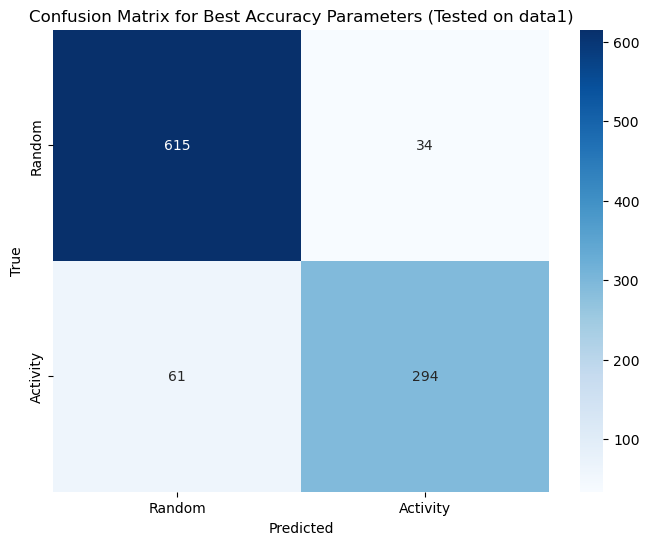

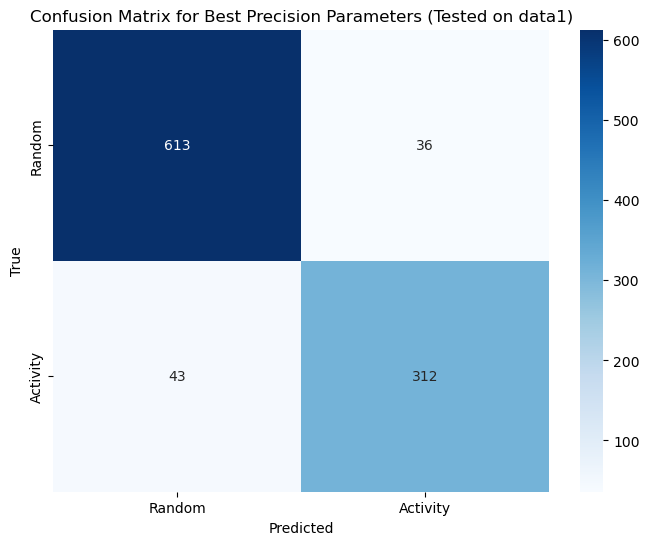

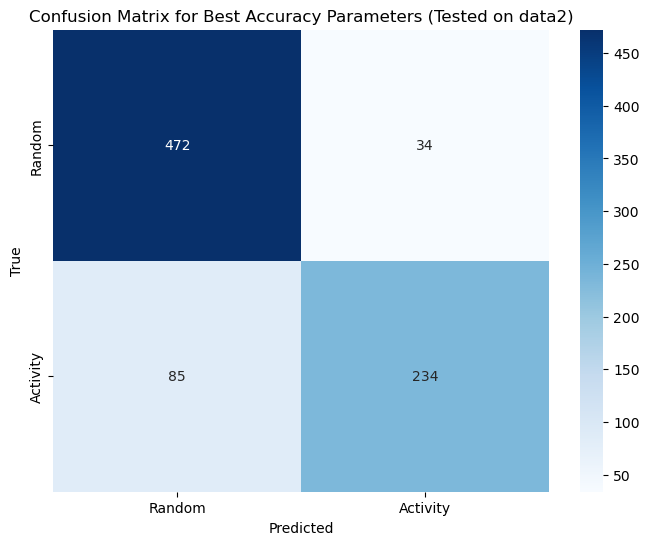

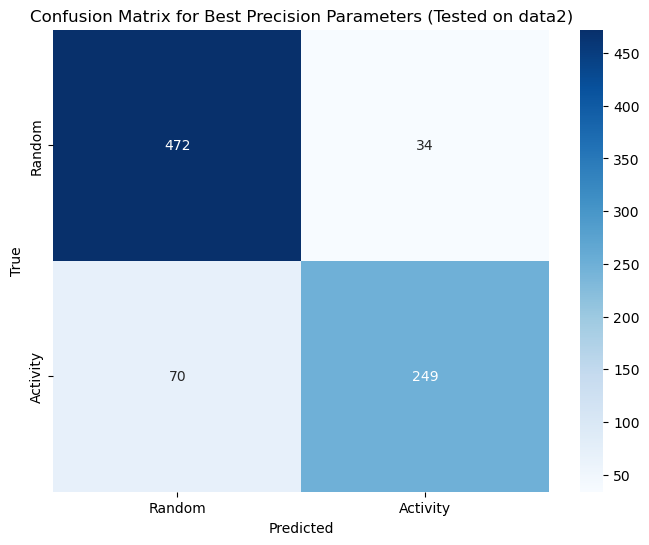

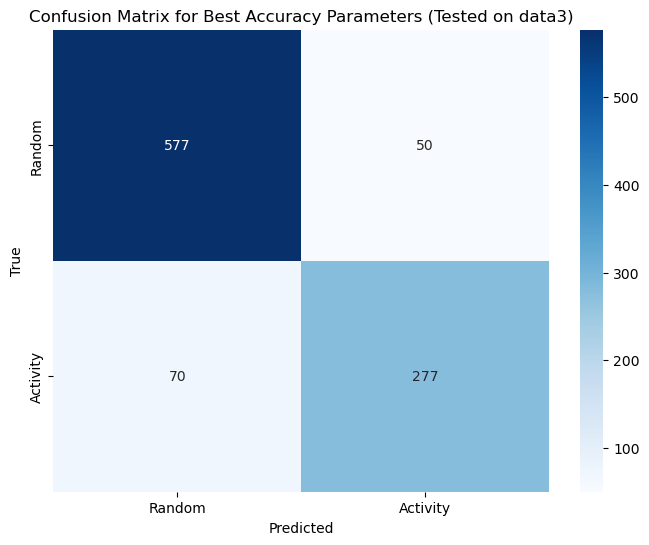

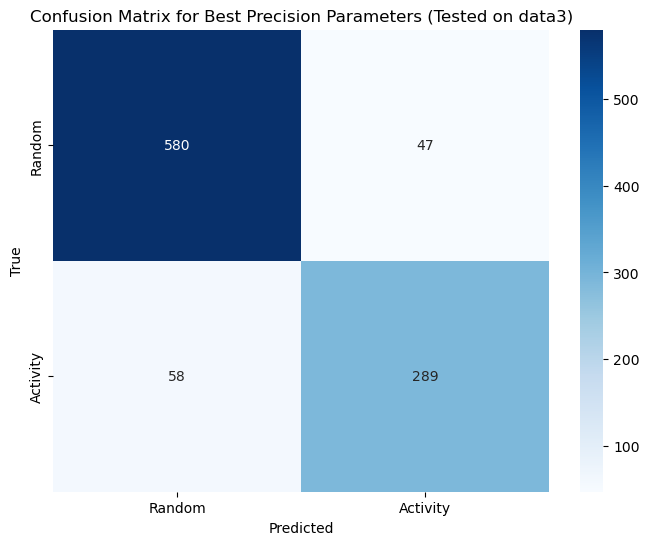

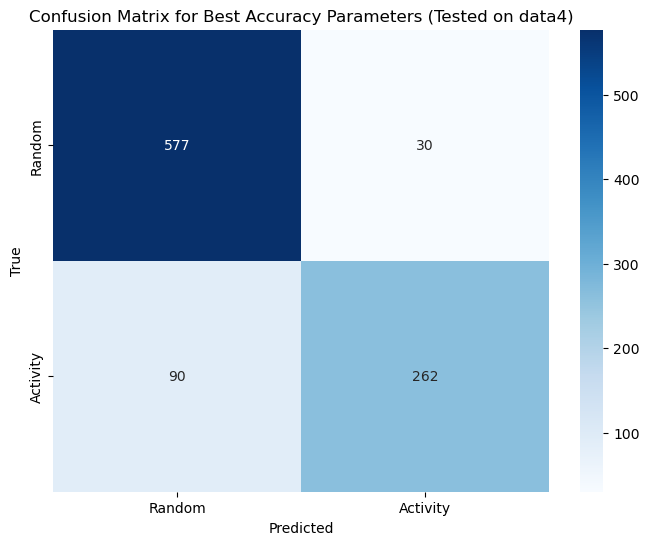

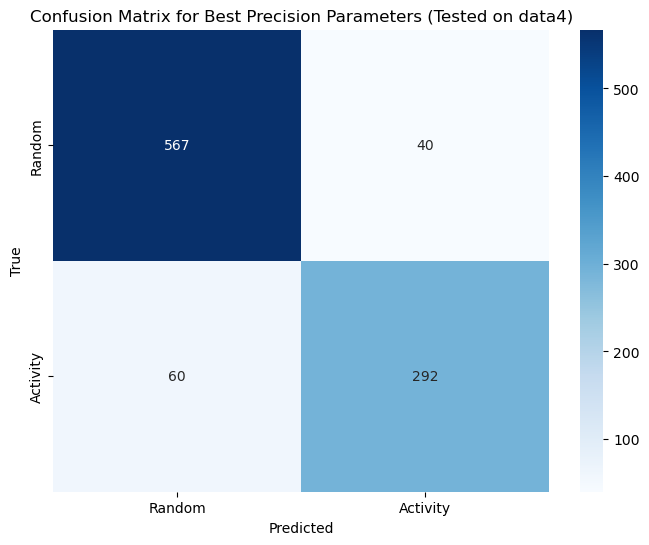

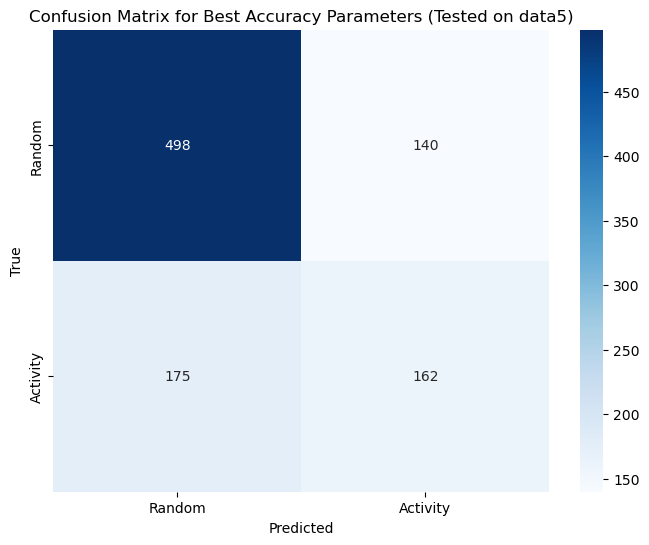

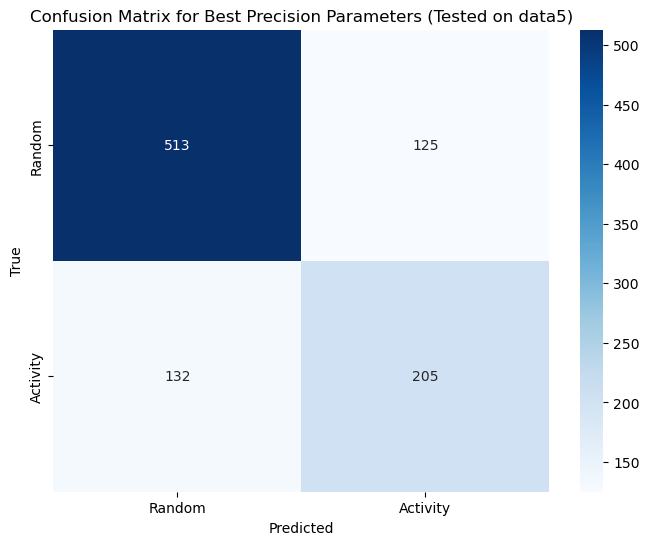

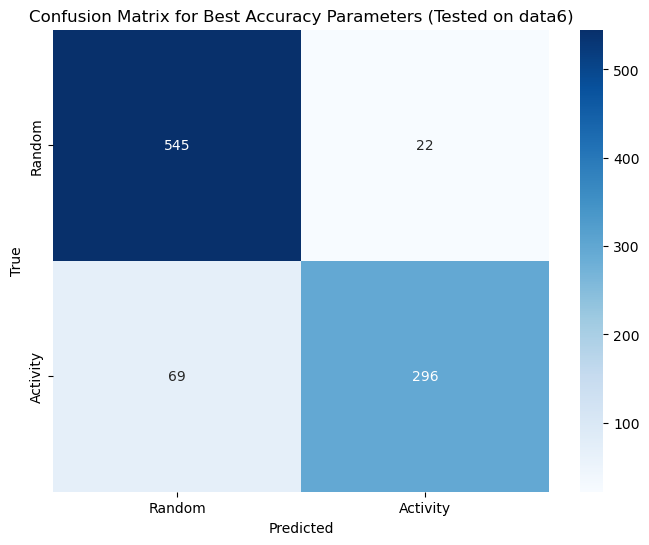

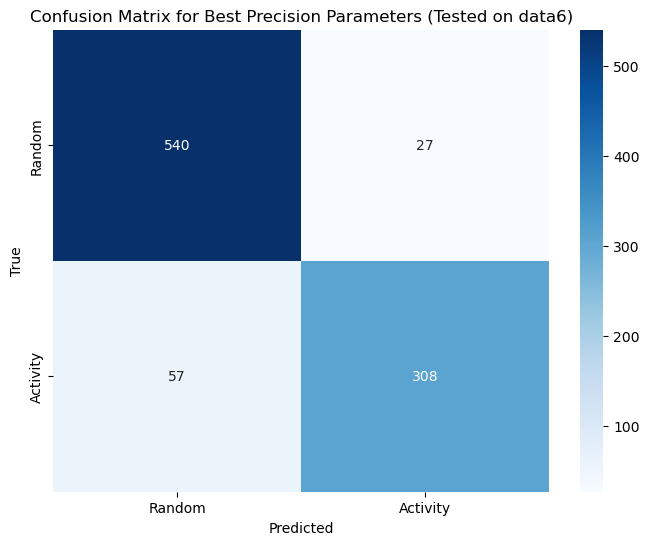

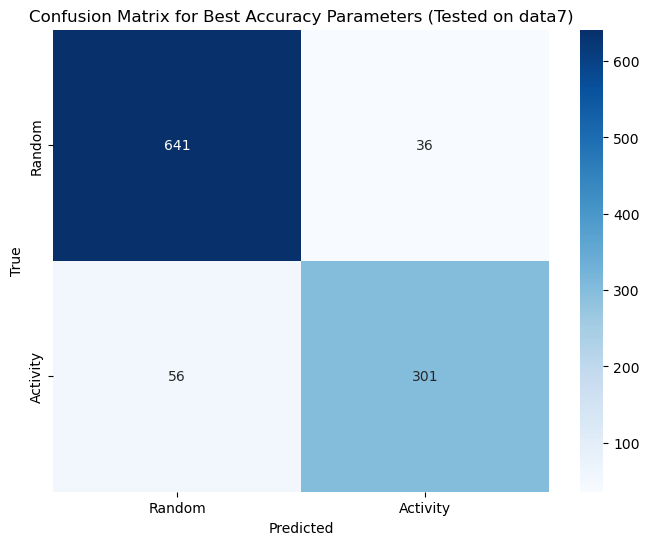

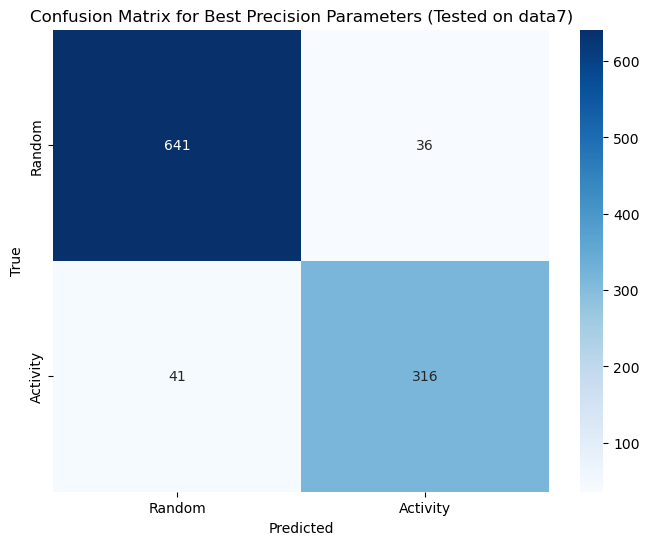

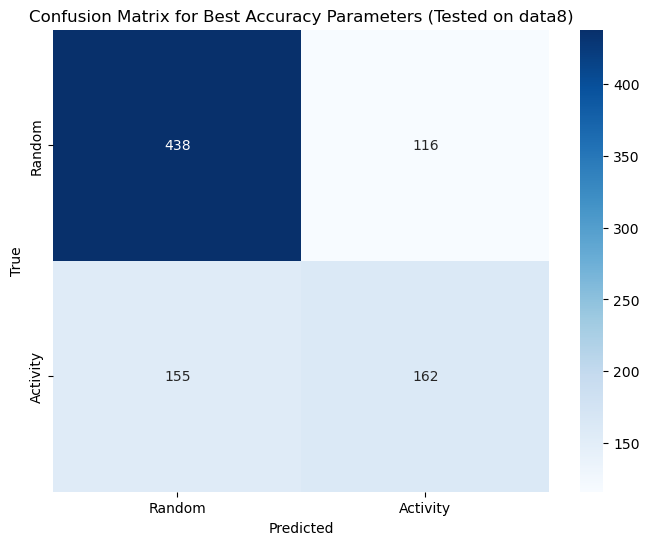

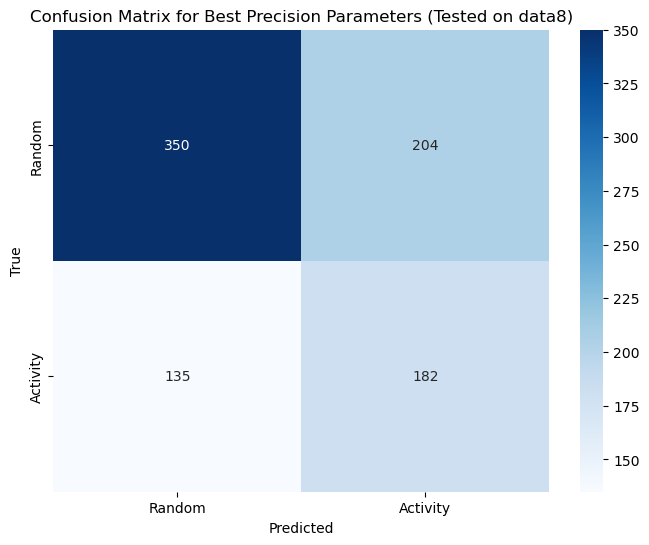

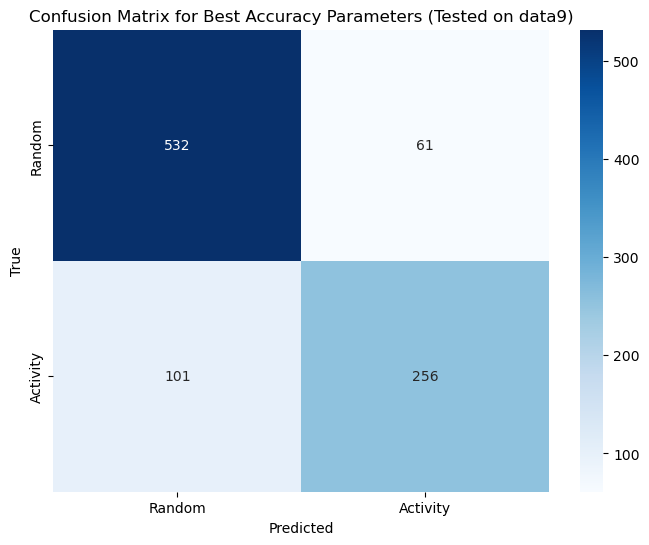

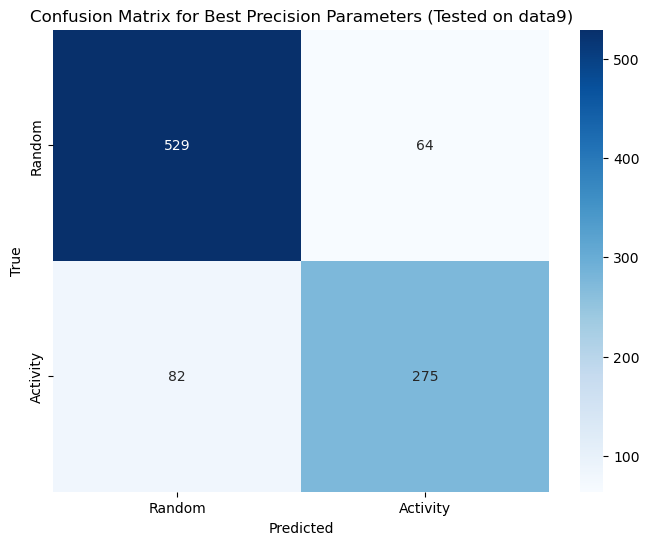

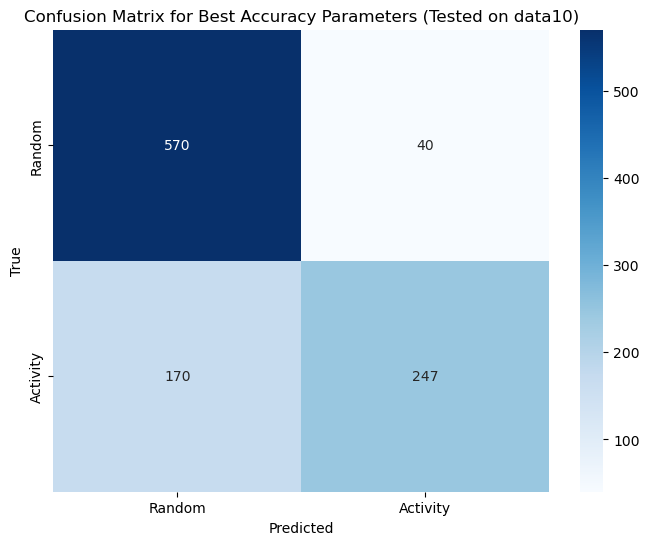

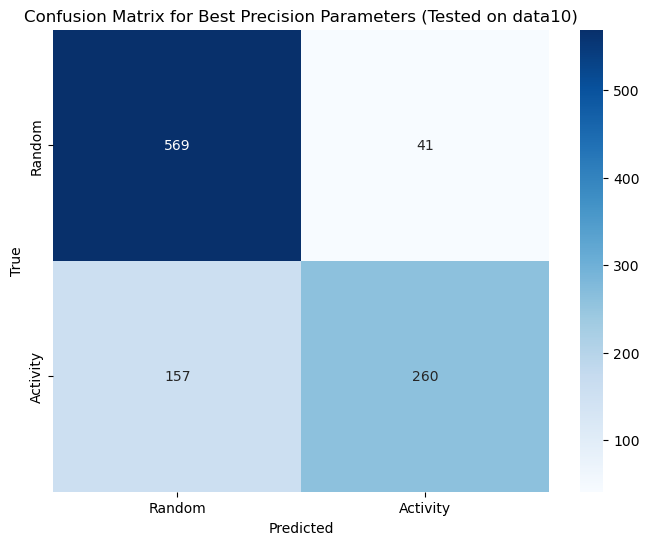

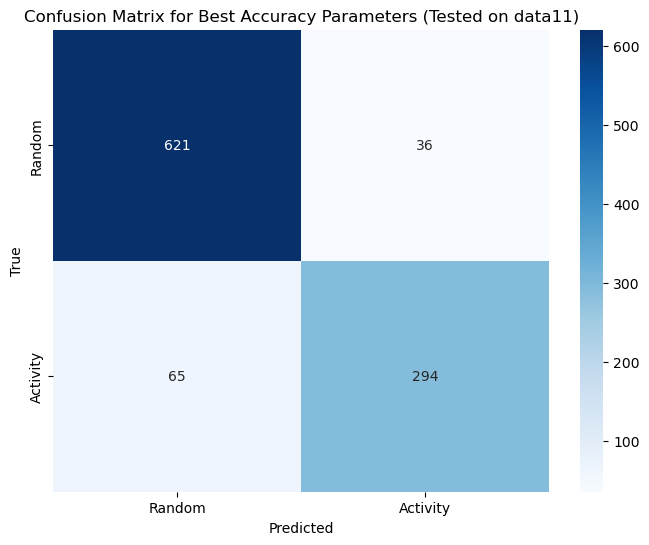

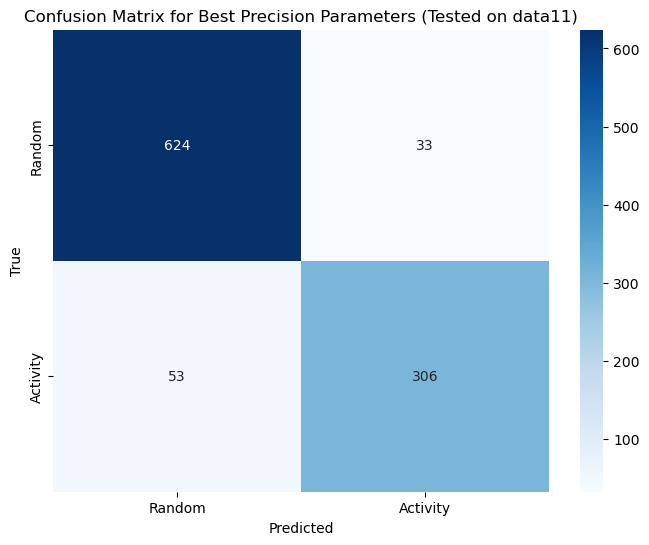

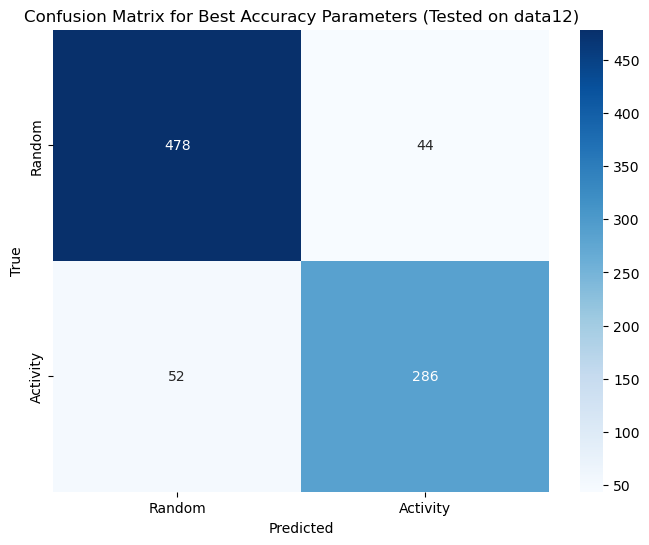

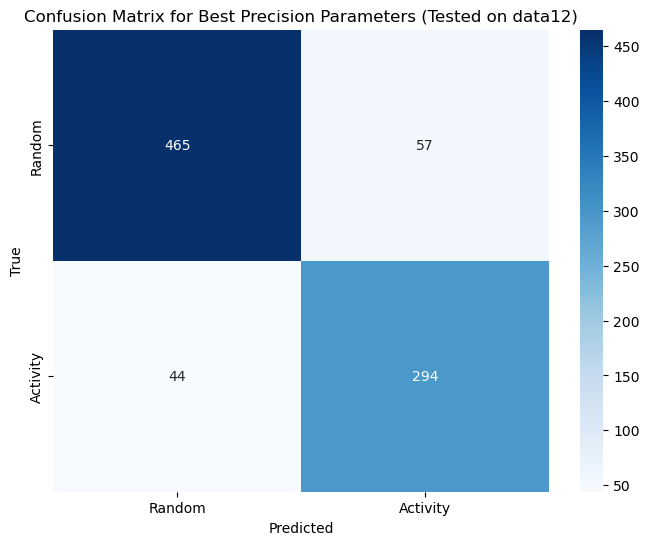

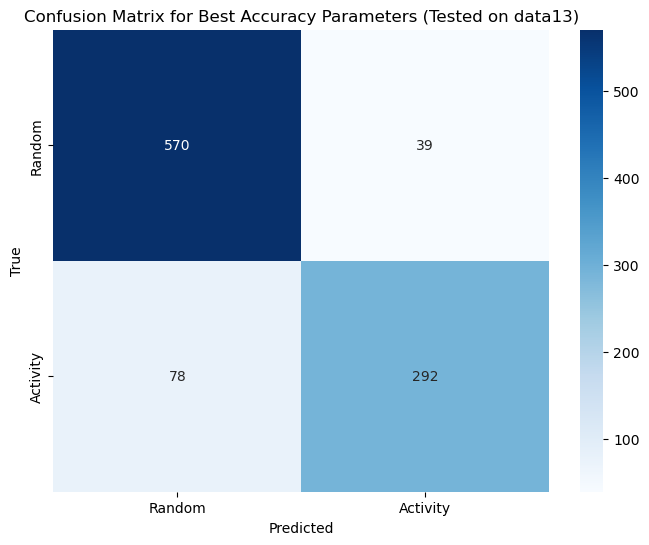

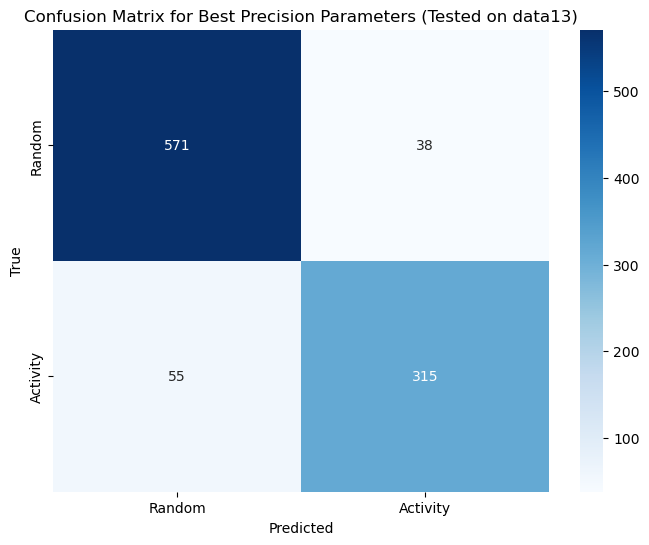

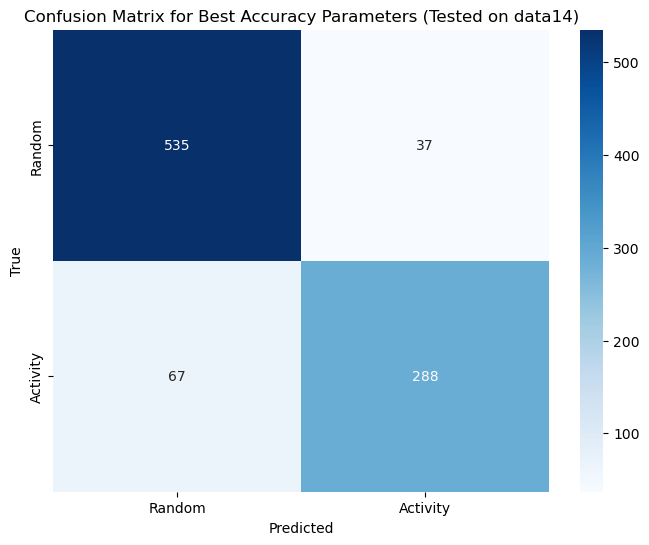

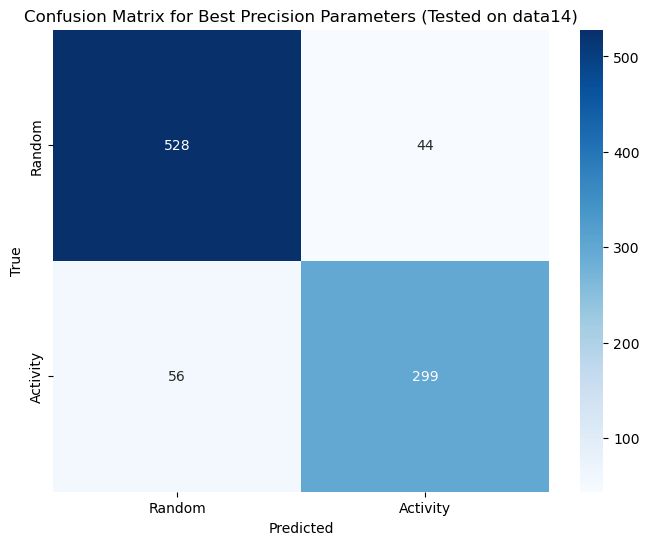

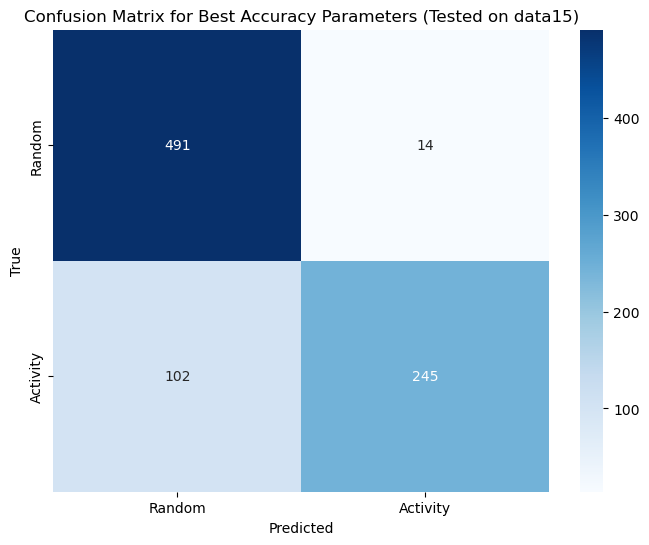

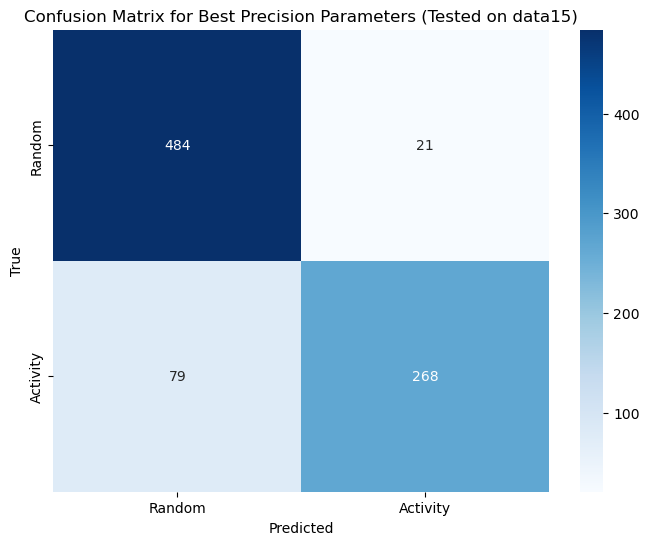

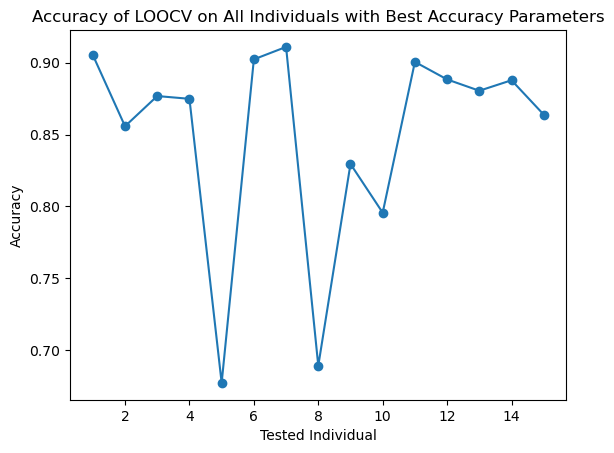

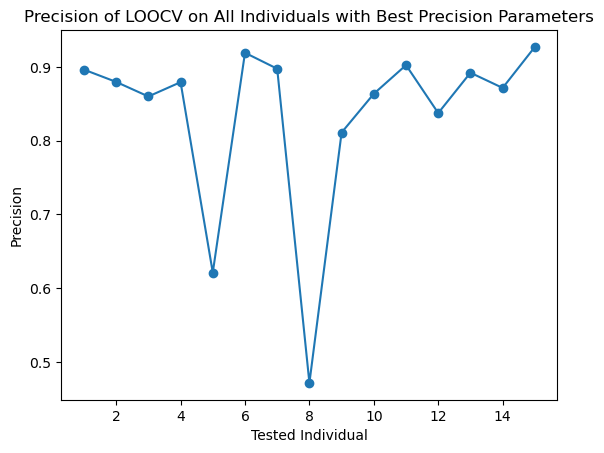

Average Accuracy with Best Accuracy Parameters:  0.8492054673079489
Average Precision with Best Precision Parameters:  0.835503868155223


In [ ]:
# Step 3: Optimize the Objective Function
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=100)

# Step 4: Retrieve the Best Parameters
best_params_accuracy = study.best_trials[0].params
best_params_precision = study.best_trials[1].params

print(f"Best parameters for accuracy: {best_params_accuracy}")
print(f"Best parameters for precision: {best_params_precision}")
# Evaluate with the best parameters
LOOCVAccuracy = np.array([])
LOOCVPrecision = np.array([])

for tester in dataframes:
    # Prepare training and test data
    testingFeatures = dataframes[tester].drop(columns=['activity']).to_numpy()
    testingActivity = dataframes[tester]['activity'].to_numpy()

    X_train = pd.DataFrame()
    y_train = pd.DataFrame()
    for trainer in dataframes:
        if trainer != tester:
            X_train = pd.concat([X_train, dataframes[trainer].drop(columns=['activity'])], ignore_index=True)
            y_train = pd.concat([y_train, dataframes[trainer]['activity']], ignore_index=True)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy().flatten()

    # Standardize the data
    scaler = StandardScaler()
    testingFeatures = scaler.fit_transform(testingFeatures)
    X_train = scaler.fit_transform(X_train)

    # Using best parameters for accuracy
    rf_acc = RandomForestClassifier(**best_params_accuracy)
    rf_acc.fit(X_train, y_train)
    y_pred_acc = rf_acc.predict(testingFeatures)

    cmat_acc = confusion_matrix(testingActivity, y_pred_acc)
    labels = ["Random", "Activity"]

    # Plot confusion matrix for accuracy
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat_acc, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Best Accuracy Parameters (Tested on {tester})")
    plt.show()

    LOOCVAccuracy = np.append(LOOCVAccuracy, accuracy_score(testingActivity, y_pred_acc))

    # Using best parameters for precision
    rf_prec = RandomForestClassifier(**best_params_precision)
    rf_prec.fit(X_train, y_train)
    y_pred_prec = rf_prec.predict(testingFeatures)

    cmat_prec = confusion_matrix(testingActivity, y_pred_prec)

    # Plot confusion matrix for precision
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmat_prec, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for Best Precision Parameters (Tested on {tester})")
    plt.show()

    LOOCVPrecision = np.append(LOOCVPrecision, precision_score(testingActivity, y_pred_prec, zero_division=0))

# Plot accuracy and precision
plt.plot(np.arange(1, len(LOOCVAccuracy) + 1), LOOCVAccuracy, marker='o')
plt.title("Accuracy of LOOCV on All Individuals with Best Accuracy Parameters")
plt.xlabel("Tested Individual")
plt.ylabel("Accuracy")
plt.show()

plt.plot(np.arange(1, len(LOOCVPrecision) + 1), LOOCVPrecision, marker='o')
plt.title("Precision of LOOCV on All Individuals with Best Precision Parameters")
plt.xlabel("Tested Individual")
plt.ylabel("Precision")
plt.show()

print("Average Accuracy with Best Accuracy Parameters: ", np.mean(LOOCVAccuracy))
print("Average Precision with Best Precision Parameters: ", np.mean(LOOCVPrecision))